# Pre-procesamiento de imagen
El proyecto tendrá como objetivo la identificacion de rostro. 
Para esto se usará una red pre-entrenada que es capaz de reconocer el area del rostro posando de manera frontal.


## Propuesta de pre-procesamiento del dato

El objetivo es conectar el programa a la camará de algún dispositivo a disposición del usuario:

1. Del video se extraerán imagenes
2. De cada imagen se identificará el rostro eliminando información no util, por ejemplo, el fondo, las orejas, cabello y cuello.
3. Se pone en escala de grises
4. Se redimensionan las imagenes

## Obtener el vido desde la cámara

En este caso se usará la cámara del PC para obtener un vídeo del rostro de la persona.

In [1]:
# Librerias en uso


import os
import math   
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd

import cv2     # Para capturar videos
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

import tensorflow as tf


import dlib # Extraer rostro
from google.colab.patches import cv2_imshow

In [2]:
'''
Tomado de https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=iU_0F2SVW4Yb
'''
from IPython.display import display, Javascript,HTML
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      
      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
    
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      video.muted = true;

      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);

      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

In [3]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):
  
  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [31]:
video_path = "camara.mp4"
record_video(video_path)

<IPython.core.display.Javascript object>

Finished recording video at:camara.mp4


In [32]:
show_video(video_path)

# Reconocimiento facial
Una vez se obtiene el video se van a extraer 3 fotogramas donde solo se tiene tiene la imagen de la cara de la persona, para esto se usa la red pre-entrenada dlib

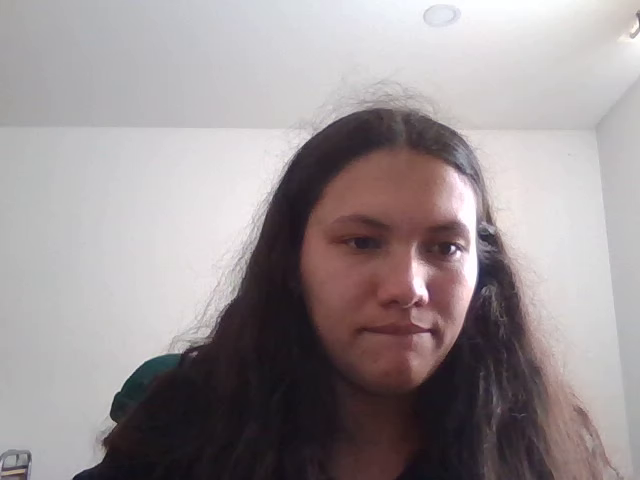

In [8]:
cap = cv2.VideoCapture(video_path)
f, im = cap.read()
cv2_imshow(im)

In [9]:
'''
Se extraen las caracteristicas del video  (frames,dimensiones)
'''
#Count frames
def count_frames(video):
    vc = cv2.VideoCapture(video)
    c=1

    if vc.isOpened():
        rval , frame = vc.read()
    else:
        rval = False
        print(8)
    while rval:
        rval, frame = vc.read()
        #cv2.imwrite(str(c) + '.jpg',frame)
        c = c + 1
        cv2.waitKey(1)
    vc.release()
    return c

video1 =cv2.VideoCapture('/content/test.mp4')
frames = int(cv2.CAP_PROP_FRAME_COUNT) 
altura= int(cv2.CAP_PROP_FRAME_WIDTH)
ancho= int(cv2.CAP_PROP_FRAME_HEIGHT)

print('frames =',count_frames(video_path))
print('Altura frame =', cv2.VideoCapture.get(video1, altura))
print('Ancho frame =', cv2.VideoCapture.get(video1, ancho))

frames = 130
Altura frame = 640.0
Ancho frame = 480.0


In [10]:
# Iniciar el dlib's face detector
detector = dlib.get_frontal_face_detector()
#Detectar la ubicación del rostro
faces = detector(im)
print(faces)

rectangles[[(313, 194) (492, 373)]]


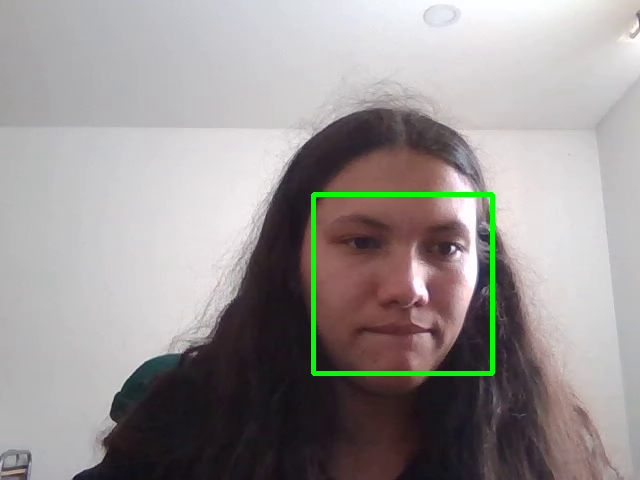

In [11]:
# Identificar la hubicación del rostro
for face in faces:
  x1=face.left()
  y1=face.top()
  x2=face.right()
  y2=face.bottom()
# Dibujar un rectangulo sobre el rostro
  cv2.rectangle(im, (x1,y1), (x2,y2),(0,255,0),3)
cv2_imshow(im)

convertiremos los videos a escala de grises y reduciremos su resolución de 1280x720 a 256x144 y tambien reduciremos la cantidad de frames a la mitad, con esto, el video tendrá al rededor de 61 frames. en terminos de memoria, el video pasa de ocupar alproximadamente 3MB a 88KB.

La siguiente función se diseño para:

* reducir la resolución del video
* Dejarlo en escala de grises
* Extraer los rostros:  se usará un detector facial pre-entrenado ya existente "dlib"
* Luego se extraen las coordenadas del recuadro que contiene el rostro
* Se extrae la imagen que contiene sólo el rostro y se escala a un tamaño unico de (48,48) pixeles.

In [30]:
list(range(1,14,14//3))[:3]

[1, 5, 9]

In [110]:
def scala_recorte_y_gris(video_original,scala=(256,144),tamano=(48,48),nframes=3):
  '''
  scala y tamaño de frame respuesta
  nframes : cantidad de imagenes a analizar

  '''
  i=1
  cap = cv2.VideoCapture(video_original)
  n=count_frames(video_original) #número de frames en el video
  #Vamos a eliminar los frmaes sobrantes 
  frames = list (range(1,n,n//nframes))[:nframes] #lista de frames a conservar
  r=[]
  
  while True:
    ret, frame = cap.read()
    
    if ret == True:  #mientras se reciba un frame del video
      if i in frames:
        b = cv2.resize(frame,scala,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)#se redimensiona cada frame
        b= cv2.cvtColor(b, cv2.COLOR_BGR2GRAY) #cada frame de rgb a grices
        im= b
        detector = dlib.get_frontal_face_detector() #detector de rostro
        faces = detector(im)
        
        for face in faces:
          x1=face.left()
          y1=face.top()
          x2=face.right()
          y2=face.bottom()

        sub_face = im[y1:y2, x1:x2]
        sub_face= cv2.resize(sub_face,tamano,fx=0,fy=0, interpolation = cv2.INTER_CUBIC) # tamaño cuadrado de la imagen solo con el rostro
        im=sub_face
        im=tf.convert_to_tensor(im)
        im=tf.reshape(im,(1,)+tamano)
        
        if i==1:
              array=im
        else:
              array=tf.concat([array,im],0)
        r.append(i)
      i+=1
      
    else:
      break
  cap.release()
  cv2.destroyAllWindows() #cierra el proceso con el video
  return array

In [112]:
scala=(256,144)
rostro=scala_recorte_y_gris(video_path)

<Figure size 432x288 with 0 Axes>

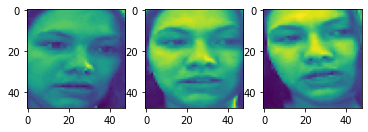

In [122]:
plt.figure()

f, axarr = plt.subplots(1,nframes) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(rostro[0])
axarr[1].imshow(rostro[1])
axarr[2].imshow(rostro[2])

